# Image generation with Stable Diffusion XL and OpenVINO

Stable Diffusion XL or SDXL is the latest image generation model that is tailored towards more photorealistic outputs with more detailed imagery and composition compared to previous Stable Diffusion models, including Stable Diffusion 2.1.

With Stable Diffusion XL you can now make more realistic images with improved face generation, produce legible text within images, and create more aesthetically pleasing art using shorter prompts.

![pipeline](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/resolve/main/pipeline.png)

[SDXL](https://arxiv.org/abs/2307.01952) consists of an [ensemble of experts](https://arxiv.org/abs/2211.01324) pipeline for latent diffusion: In the first step, the base model is used to generate (noisy) latents, which are then further processed with a refinement model specialized for the final denoising steps. Note that the base model can be used as a standalone module or in a two-stage pipeline as follows: First, the base model is used to generate latents of the desired output size. In the second step, we use a specialized high-resolution model and apply a technique called [SDEdit](https://arxiv.org/abs/2108.01073)( also known as "img2img") to the latents generated in the first step, using the same prompt. 

Compared to previous versions of Stable Diffusion, SDXL leverages a three times larger UNet backbone: The increase of model parameters is mainly due to more attention blocks and a larger cross-attention context as SDXL uses a second text encoder. The authors design multiple novel conditioning schemes and train SDXL on multiple aspect ratios and also introduce a refinement model which is used to improve the visual fidelity of samples generated by SDXL using a post-hoc image-to-image technique. The testing of SDXL shows drastically improved performance compared the previous versions of Stable Diffusion and achieves results competitive with those of black-box state-of-the-art image generators.

In this tutorial, we consider how to run SDXL model using OpenVINO.

We will use a pre-trained model from the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format.

The tutorial consists of the following steps:

- Install prerequisites
- Download and convert the model from a public source using the [OpenVINO integration with Hugging Face Optimum](https://huggingface.co/blog/openvino).
- Create an instruction-following inference pipeline
- Run instruction-following pipeline


## Prerequisites

In [1]:
!pip install -q "git+https://github.com/huggingface/optimum-intel.git"
!pip install "openvino-dev==2023.1.0.dev20230728"
!pip install -q --upgrade-strategy eager "diffusers>=0.18.0" "invisible-watermark>=0.2.0" "transformers>=4.30.2" "accelerate" "onnx" "onnxruntime"

## SDXL Base model

We will start with the base model part, which is responsible for the generation of images of the desired output size. 
[stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) is available for downloading via the [HuggingFace hub](https://huggingface.co/models). It already provides a ready-to-use model in OpenVINO format compatible with [Optimum Intel](https://huggingface.co/docs/optimum/intel/index).

To load an OpenVINO model and run inference with OpenVINO Runtime, you need to replace `StableDiffusionXLPipeline` with Optimum `OVStableDiffusionXLPipeline`. In case you want to load a PyTorch model and convert it to the OpenVINO format on-the-fly, you can set `export=True`.  

You can save model on disk using `save_pretrained` method.

In [2]:
from pathlib import Path
from optimum.intel.openvino import OVStableDiffusionXLPipeline
import gc

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
model_dir = Path("openvino-sd-xl-base-1.0")
if not model_dir.exists():
    text2image_pipe  = OVStableDiffusionXLPipeline.from_pretrained(model_id, compile=False)
    text2image_pipe.half()
    text2image_pipe.save_pretrained(model_dir)
    text2image_pipe.compile()
else:
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir)

2023-08-01 19:21:44.538102: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 19:21:44.578061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 19:21:45.208693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Fetching 33 files:   0%|          | 0/33 [00:00<?, ?it/s]

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder...
Compiling the vae_encoder...
Compiling the text_encoder_2...


### Run Text2Image generation pipeline

Now, we can run the model for the generation of images using text prompts. To speed up evaluation and reduce the required memory we decrease `num_inference_steps` and image size (using `height` and `width`).  You can modify them to suite your needs and depend on target hardware. We also specified `generator` parameter based on numpy random state with a specific seed for results reproducibility.

/home/ea/work/ov_notebooks_env/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:552: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


  0%|          | 0/15 [00:00<?, ?it/s]

/home/ea/work/ov_notebooks_env/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:583: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)
/home/ea/work/ov_notebooks_env/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:599: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


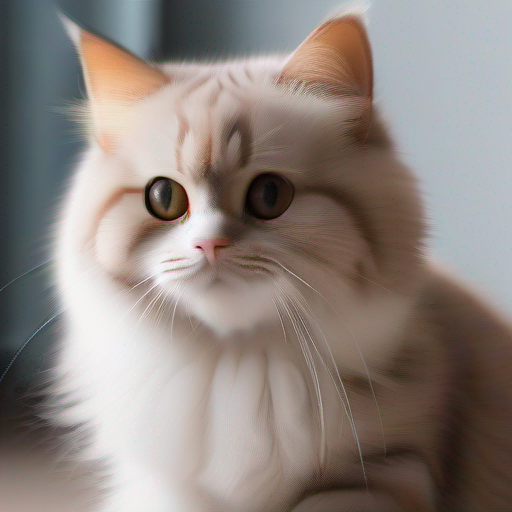

In [3]:
import numpy as np

prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
image = text2image_pipe(prompt, num_inference_steps=10, height=512, width=512, generator=np.random.RandomState(314)).images[0]
image.save("cat.png")
image

### Text2imge Generation Interactive Demo 

In [4]:
del text2image_pipe
gc.collect()

308

### Run Image2Image generation pipeline

We can reuse already converted model for running Image2Image generation pipeline. For that we should replace `OVStableDiffusionXLPipeline` with `OVStableDiffusionXLImage2ImagePipeline`.

In [5]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline

image2image_pipe = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(model_dir)

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the vae_encoder...
Compiling the text_encoder...


/home/ea/work/ov_notebooks_env/lib/python3.8/site-packages/optimum/pipelines/diffusers/pipeline_utils.py:64: FutureWarning: The preprocess method is deprecated and will be removed in a future version. Please use VaeImageProcessor.preprocess instead
  warnings.warn(
/home/ea/work/ov_notebooks_env/lib/python3.8/site-packages/optimum/intel/openvino/modeling_diffusion.py:615: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  outputs = self.request(inputs, shared_memory=True)


  0%|          | 0/15 [00:00<?, ?it/s]

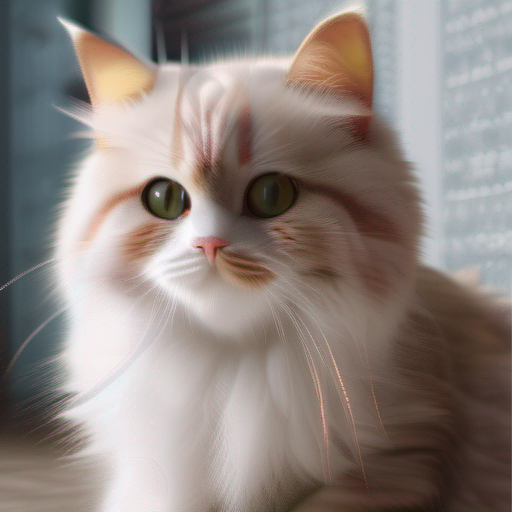

In [6]:
photo_prompt = f"professional photo of a cat, extremely detailed, hyper realistic, best quality, full hd"
photo_image = image2image_pipe(photo_prompt, image=image, num_inference_steps=25, generator=np.random.RandomState(356)).images[0]
photo_image.save("photo_cat.png")
photo_image

### Image2imge Generation Interactive Demo 

In [7]:
del image2image_pipe
gc.collect()

193

## SDXL Refiner model

As we discussed above, Stable Diffusion XL can be used in a 2-stages approach: first, the base model is used to generate latents of the desired output size. In the second step, we use a specialized high-resolution model for the refinement of latents generated in the first step, using the same prompt. 
The Stable Diffusion XL Refiner model is designed to transform regular images into stunning masterpieces with the help of user-specified prompt text. It can be used to improve the quality of image generation after the Stable Diffusion XL Base. The model accepts latents produced by SDXL base model and text prompt for improving generated image.

In [8]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline, OVStableDiffusionXLPipeline
from pathlib import Path

refiner_model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"
refiner_model_dir = Path("openvino-sd-xl-refiner-1.0")


if not refiner_model_dir.exists():
    refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, export=True, compile=False)
    refiner.save_pretrained(refiner_model_dir)
    del refiner
    gc.collect()

In [9]:
import numpy as np
import gc
model_dir = Path("openvino-sd-xl-base-1.0")
base = OVStableDiffusionXLPipeline.from_pretrained(model_dir)
prompt = "cute cat 4k, high-res, masterpiece, best quality, soft lighting, dynamic angle"
latents = base(prompt, num_inference_steps=15, height=512, width=512, generator=np.random.RandomState(314), output_type="latent").images[0]

del base
gc.collect()

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder...
Compiling the text_encoder_2...
Compiling the vae_encoder...


  0%|          | 0/15 [00:00<?, ?it/s]

204

In [10]:
refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_dir)

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the vae_encoder...


In [11]:
image = refiner(prompt=prompt, image=latents[None, :], num_inference_steps=15, generator=np.random.RandomState(314)).images[0]
image.save("cat_refined.png")

image

  0%|          | 0/4 [00:00<?, ?it/s]